# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [2]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
from langdetect import detect
from textblob import TextBlob
from wordcloud import WordCloud
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [52]:
# Le doy formato a los gráficos
# sns.set_style("darkgrid")
sns.set_style("white")
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

time: 0 ns (started: 2021-09-07 20:05:44 -03:00)


In [4]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

time: 0 ns (started: 2021-09-07 19:57:11 -03:00)


In [5]:
# Definimos si queres procesar el dataset crudo
READ_RAW = False
DETECT_LANG = False
GET_SUBJECTIVITY = False
GET_POLARITY = False

time: 0 ns (started: 2021-09-07 19:57:11 -03:00)


In [6]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

time: 0 ns (started: 2021-09-07 19:57:11 -03:00)


**Reviews**

In [7]:
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

time: 0 ns (started: 2021-09-07 19:57:11 -03:00)


In [8]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

time: 7.27 s (started: 2021-09-07 19:57:11 -03:00)


In [9]:
data_reviews.head(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030368.0000,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396848.0000,NaN,NaN
5,Szudof,0.2000,155.0000,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,NaN,Product received for free,3.0000
6,Vonder,2.7000,264.0000,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497328.0000,NaN,NaN
7,LucaFox,4.0000,136.0000,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674480.0000,NaN,1.0000
8,rampage1209,34.8000,3.0000,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474368.0000,NaN,NaN
9,Devil Azite,0.1000,548.0000,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,NaN,Product received for free,1.0000


time: 78 ms (started: 2021-09-07 19:57:18 -03:00)


In [10]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

time: 187 ms (started: 2021-09-07 19:57:18 -03:00)


In [11]:
data_reviews.dropna(subset=['text'], axis=0, inplace=True)

time: 203 ms (started: 2021-09-07 19:57:19 -03:00)


In [12]:
data_reviews.isna().sum()

username            18
hours             2625
products          1564
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         460624
compensation    762923
found_funny     657709
dtype: int64

time: 172 ms (started: 2021-09-07 19:57:19 -03:00)


**Games**

In [13]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

time: 3.12 s (started: 2021-09-07 19:57:19 -03:00)


In [14]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


time: 15 ms (started: 2021-09-07 19:57:22 -03:00)


Vamos a reducir las columnas de *'data_reviews'*

In [15]:
data_reviews.columns

Index(['username', 'hours', 'products', 'product_id', 'page_order', 'date',
       'text', 'early_access', 'page', 'user_id', 'compensation',
       'found_funny'],
      dtype='object')

time: 0 ns (started: 2021-09-07 19:57:22 -03:00)


In [16]:
df_reviews = data_reviews[['username', 'product_id', 'text', 'found_funny', 'hours']]
df_reviews.head()

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,NaN,7.8000
4,the_maker988,35140,"This game was way to linear for me, and compar...",NaN,8.2000


time: 47 ms (started: 2021-09-07 19:57:22 -03:00)


In [17]:
# Creamos método para eliminar los caracteres que no sean letras
def cleanText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^A-Za-z]"," ",str(text))
    return text

time: 0 ns (started: 2021-09-07 19:57:22 -03:00)


In [18]:
# Aplicamos el método a la columna de texto
df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)

  0%|          | 0/777468 [00:00<?, ?it/s]

time: 24.8 s (started: 2021-09-07 19:57:22 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_9780/3370166507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)


In [19]:
df_reviews

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000
...,...,...,...,...,...
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000
779303,Nikolai Belinski,252490,Coolest Game Eva,NaN,55.1000
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000
779305,Jerry,252490,Great game,NaN,139.8000


time: 16 ms (started: 2021-09-07 19:57:47 -03:00)


Detectar idioma del texto

In [20]:
# Creamos función para detectar idioma
def getLang(text):
    try:
        lang = detect(text)                                     
    except:
        lang = np.NaN
    return lang

time: 0 ns (started: 2021-09-07 19:57:47 -03:00)


In [21]:
if DETECT_LANG:
    df_reviews['lang'] = df_reviews['text'].progress_apply(getLang)

time: 0 ns (started: 2021-09-07 19:57:47 -03:00)


In [22]:
if DETECT_LANG:
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv', index_col='index')

time: 7.09 s (started: 2021-09-07 19:57:47 -03:00)


In [23]:
df_reviews.lang.unique()

array(['en', nan, 'so', 'pl', 'de', 'it', 'fr', 'ca', 'sw', 'tr', 'af',
       'hr', 'tl', 'no', 'es', 'ro', 'vi', 'nl', 'sq', 'cy', 'pt', 'id',
       'lv', 'et', 'hu', 'lt', 'da', 'sl', 'sk', 'fi', 'sv', 'cs', 'uk'],
      dtype=object)

time: 47 ms (started: 2021-09-07 19:57:54 -03:00)


In [24]:
code = pd.read_csv('lang_code3.csv')
code_dict = code.set_index('code').to_dict()['language_name']
df_reviews['lang'] = df_reviews['lang'].map(code_dict)

time: 94 ms (started: 2021-09-07 19:57:54 -03:00)


In [25]:
idiomas = df_reviews.groupby('lang').count()['username'].sort_values(ascending=False)

time: 218 ms (started: 2021-09-07 19:57:54 -03:00)


In [26]:
idiomas.index

Index(['English', 'Somali', 'German', 'Afrikaans', 'Tagalog', 'Welsh',
       'Norwegian', 'Danish', 'Romanian', 'Spanish', 'Dutch', 'Catalan',
       'French', 'Indonesian', 'Italian', 'Polish', 'Portuguese', 'Turkish',
       'Estonian', 'Swahili', 'Slovenian', 'Albanian', 'Croatian',
       'Vietnamese', 'Swedish', 'Finnish', 'Hungarian', 'Slovak', 'Lithuanian',
       'Latvian', 'Czech', 'Ukrainian'],
      dtype='object', name='lang')

time: 16 ms (started: 2021-09-07 19:57:55 -03:00)


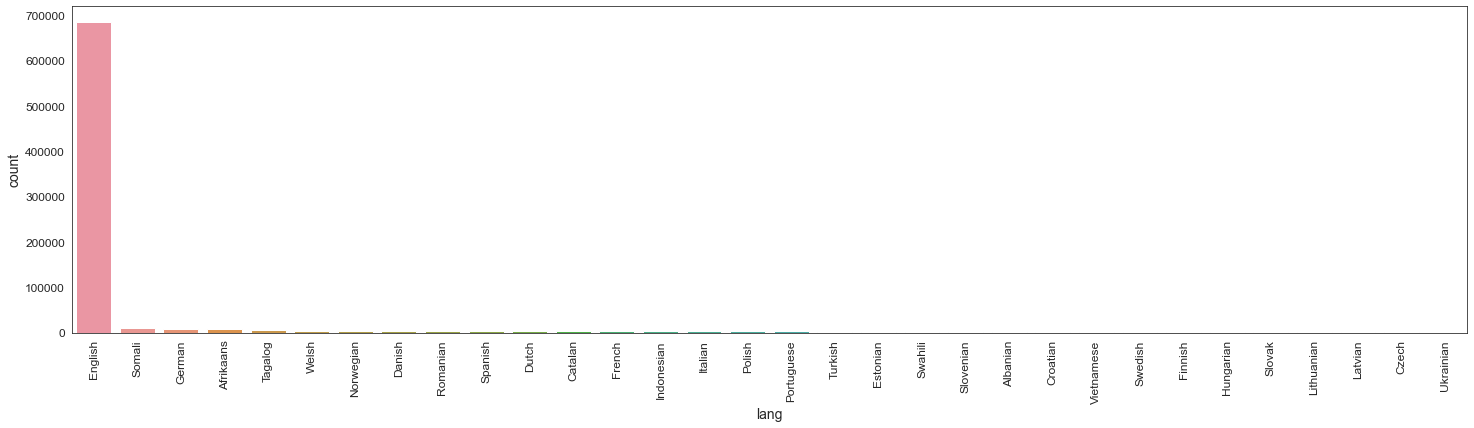

time: 1.05 s (started: 2021-09-07 19:57:55 -03:00)


In [27]:
# Graficamos el conteo de los distintos idiomas encontrados en el dataset
plt.figure(figsize=(25,6))
sns.countplot(data=df_reviews, x='lang', order=idiomas.index[0:])
plt.xticks(rotation=90)
plt.show()

Vemos claramante que el idioma predominantes es el inglés. Algo llamativo es que el segundo más abundante es el "Somalí". Vamos a analizar más en detalle, filtrando esas instancias.

In [28]:
df_reviews[df_reviews.lang == 'Somali'].head(20)

,username,product_id,text,found_funny,hours,lang
index,,,,,,
31,JessetheGengar,302390,baaaddddddd,NaN,0.4000,Somali
247,69:The Best Position,271590,good,NaN,176.3000,Somali
354,Santiago ♥D,308040,bad,1.0000,1.3000,Somali
445,brokensteelcache,224900,too good to play,1.0000,1.3000,Somali
601,𝖊𝖃𝖔 | Psycocat,308040,good game,NaN,3.2000,Somali
617,Vukishaa,308040,good,NaN,3.3000,Somali
698,Dicather,441050,YEAH IT CAN INTO SPACE,NaN,1.6000,Somali
718,MyAcidicPapaya,341720,good,NaN,0.8000,Somali
741,✪ B1ACKOUT,271590,good game,NaN,12.1000,Somali


time: 78 ms (started: 2021-09-07 19:57:56 -03:00)


Por lo que podemos observar, se trata de una mala predicción, ya que los comentarios están en inglés. Por alguna razón (quizás por las faltas de ortografía) los etiqueta como Somalí.
De todos modos, siendo que la cantidad de comentarios predichos como Inglés representan un gran porcentaje, vamos a eliminar aquellas instancias en otro idioma.

In [29]:
mask = df_reviews.lang == 'English'
df_reviews.drop(df_reviews[~mask].index, inplace=True)
df_reviews

,username,product_id,text,found_funny,hours,lang
index,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English
...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English


time: 187 ms (started: 2021-09-07 19:57:56 -03:00)


In [30]:
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Traemos las stopwords
stopwords = set(stopwords.words('english'))

time: 0 ns (started: 2021-09-07 19:57:56 -03:00)


In [31]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text=re.sub("[^a-zA-Z]"," ",str(text))
    # Pasamos todo a minúsculas
    text=text.lower()
    # Tokenizamos para separar las palabras del titular
    text=tokenizer.tokenize(text)
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra)>3]
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

time: 0 ns (started: 2021-09-07 19:57:56 -03:00)


In [32]:
# Aplicamos la transformación
df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)

  0%|          | 0/685202 [00:00<?, ?it/s]

time: 48 s (started: 2021-09-07 19:57:56 -03:00)


In [34]:
# Mostramos el dataset limpio
df_reviews.iloc[np.random.choice(df_reviews.index, size=5)]

,username,product_id,text,found_funny,hours,lang,cleaned_text
index,,,,,,,
347749,Matvei,107410,Suffers from glichers But spent hrs on it...,1.0000,1746.9000,English,suffers glichers spent speaks
762890,Silos,391540,Just buy the game You Will Laugh And exp...,NaN,17.6000,English,game laugh experience feels
652198,Cammy the Duck,249130,This game is really fun I didn t know anythin...,NaN,16.6000,English,game really know anything marvel playing slowl...
746653,CoyoteBongwater,457140,I purchased this game because markiplier made ...,NaN,53.0000,English,purchased game markiplier made look really tel...
552399,Crust,433950,For Cents a good deal but im afraid there...,NaN,0.2000,English,cents good deal afraid theres much else decent...


time: 16 ms (started: 2021-09-07 19:59:06 -03:00)


In [35]:
df_reviews.head(10)

,username,product_id,text,found_funny,hours,lang,cleaned_text
index,,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...
6,Vonder,35600,I like the art style and the idea but what a b...,NaN,2.7000,English,like style idea boring miserable excuse puzzle...
7,LucaFox,620900,Very very good game I love dungeon crawlers ...,1.0000,4.0000,English,good game love dungeon crawlers roguelikes lig...
8,rampage1209,1840,WAY PAST COOL,NaN,34.8000,English,past cool
9,Devil Azite,671270,Putting a hat on your head has disasterous rep...,1.0000,0.1000,English,putting head disasterous repercussions


time: 16 ms (started: 2021-09-07 19:59:07 -03:00)


In [36]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

time: 250 ms (started: 2021-09-07 19:59:08 -03:00)


In [37]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

time: 15 ms (started: 2021-09-07 19:59:09 -03:00)


In [38]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def polarity(text):
    return TextBlob(text).sentiment.polarity

time: 0 ns (started: 2021-09-07 19:59:09 -03:00)


In [39]:
if GET_SUBJECTIVITY:
    df_reviews['subj'] = df_reviews['text'].progress_apply(subjectivity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

time: 9.78 s (started: 2021-09-07 19:59:10 -03:00)


In [40]:
if GET_POLARITY:
    df_reviews['pola'] = df_reviews['text'].progress_apply(polarity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

time: 9.78 s (started: 2021-09-07 19:59:20 -03:00)


In [41]:
df2_reviews.sort_values(by='subj').iloc[650000:650050]

,index,username,product_id,text,found_funny,hours,lang,cleaned_text,subj,pola
405255,461728,Comrade Bear,70000,It s Day of Defeat with dinosaurs but that s ...,NaN,5.9000,English,defeat dinosaurs makes great,0.7500,0.8000
589424,669003,Americelt,269290,Works great with all of my games No ads or wa...,NaN,8.7000,English,works great games watermarks even works steam ...,0.7500,0.8000
293786,333230,ѼKurashikkurioѼ,238460,Grab a friend and Hammer through the most hear...,NaN,11.1000,English,grab friend hammer heart warming horrible stor...,0.7500,-0.2500
506783,576094,RubberHide,442080,its great,NaN,9.8000,English,great,0.7500,0.8000
627015,711610,Canget,49520,Great times been here,NaN,31.6000,English,great times,0.7500,0.8000
99137,112836,Galilaios,39140,One of the most beloved Jrpgs,NaN,1.6000,English,beloved jrpgs,0.7500,0.6000
260119,294760,Lostmind76,8980,A great looting and killing spree with humor a...,NaN,50.5000,English,great looting killing spree humor great weapons,0.7500,0.8000
379834,433319,Tophatphil (twitch.tv/toefat),322500,It s the most innovative shooter I ve played ...,NaN,3.3000,English,innovative shooter played years,0.7500,0.5000
247921,280887,Xenon (Xe),244870,Difficult AF and challenging but a good rage ...,NaN,0.7000,English,difficult challenging good rage game,0.7500,0.0750
647822,735885,uplasenko,518030,Nice for practicing aim but PLEASE add invert...,NaN,10.0000,English,nice practicing please invert mouse option mus...,0.7500,0.5500


time: 500 ms (started: 2021-09-07 19:59:30 -03:00)


In [42]:
df2_reviews.drop('index', axis=1, inplace=True)

time: 94 ms (started: 2021-09-07 19:59:30 -03:00)


C:\Users\elmai\.conda\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1440x864 with 0 Axes>

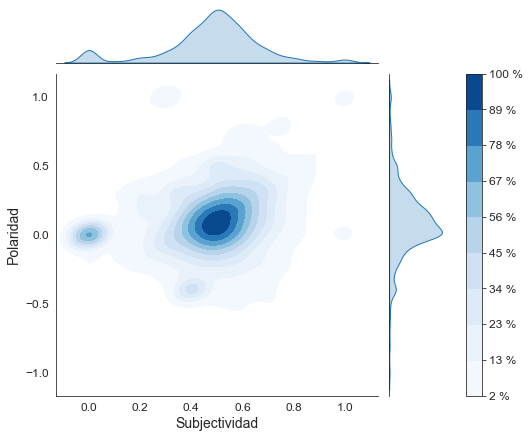

time: 5.66 s (started: 2021-09-07 20:22:14 -03:00)


In [77]:
# Graficamos para ver la distribución de las variables calculadas.

x = df2_reviews.subj[::100]
y = df2_reviews.pola[::100]

plt.figure(figsize=(20,12))
kdeplot = sns.jointplot(x, y, kind="kde", cbar=True, cmap="Blues", fill=True)

plt.subplots_adjust(left=0.1, right=1, top=1, bottom=0.1)

pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width,
                               pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([1.05, pos_joint_ax.y0, .07, pos_joint_ax.height])

# get the current colorbar ticks
cbar_ticks = kdeplot.fig.axes[-1].get_yticks()
# get the maximum value of the colorbar
_, cbar_max = kdeplot.fig.axes[-1].get_ylim()
# change the labels (not the ticks themselves) to a percentage
kdeplot.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 100:.0f} %' for t in cbar_ticks])

kdeplot.fig.axes[0].set_xlabel("Subjectividad")
kdeplot.fig.axes[0].set_ylabel("Polaridad")

plt.show()

In [78]:
df2_reviews.dropna(axis=0, subset=['username'], inplace=True)
df2_reviews.isna().sum()

username             0
product_id           0
text                 0
found_funny     579033
hours             2277
lang                 0
cleaned_text      3122
subj                 0
pola                 0
dtype: int64

time: 375 ms (started: 2021-09-07 20:22:44 -03:00)


In [79]:
reviews_count = df2_reviews.groupby('username').count().text.sort_values(ascending=False).reset_index().rename(columns={'text':'count'})
reviews_count.head()

,username,count
0,123,185
1,Alex,166
2,Chris,142
3,Nick,125
4,Matt,122


time: 1.55 s (started: 2021-09-07 20:22:54 -03:00)


C:\Users\elmai\.conda\envs\datascience\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elmai\.conda\envs\datascience\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12415 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elmai\.conda\envs\datascience\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elmai\.conda\envs\datascience\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9855 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elmai\.conda\envs\datascience\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elmai\.conda\envs\datascience\lib\site-packages\

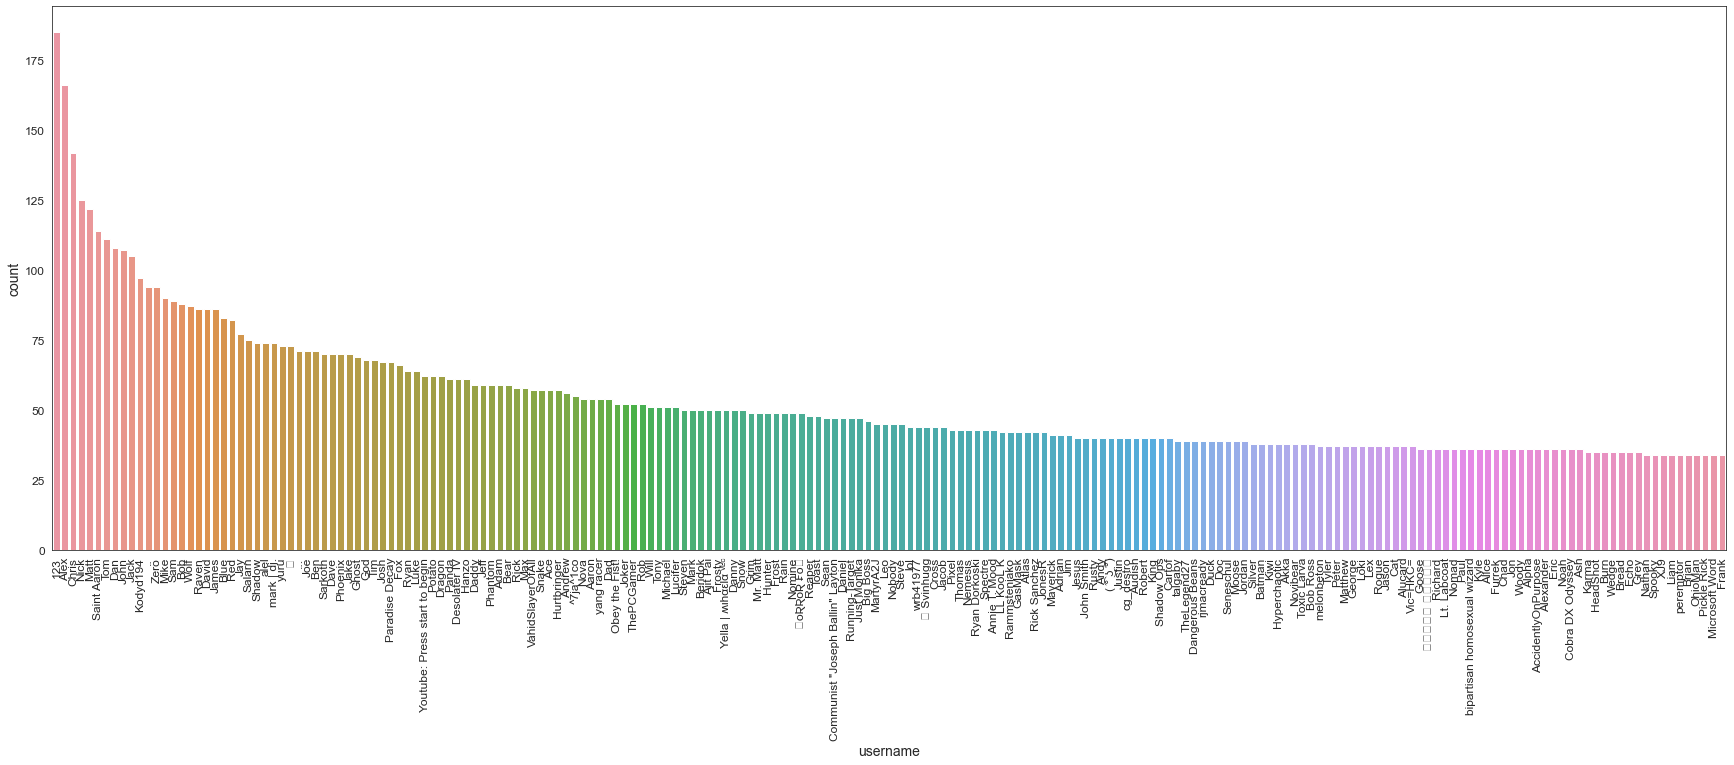

time: 14.5 s (started: 2021-09-07 20:22:58 -03:00)


In [80]:
plt.figure(figsize=(30,10))
g = sns.barplot(data=reviews_count[:200], x='username', y='count')
plt.xticks(rotation=90)
plt.show()

In [191]:
df2_reviews['rating'] = df2_reviews.apply(lambda x: (x['pola'] + 1) * 5/2 , axis=1)

time: 9.2 s (started: 2021-09-07 22:55:25 -03:00)


In [192]:
df2_reviews

,username,product_id,text,found_funny,hours,lang,cleaned_text,subj,pola,rating
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English,would acceptable entertainment even back graph...,0.0000,0.0000,2.5000
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English,addictive works fine linux though minor bugs r...,0.4250,0.0417,2.6042
2,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English,somewhere zibylon zibylon command centre read ...,0.5484,0.1652,2.9130
3,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English,game linear compared others good dollars winte...,0.3688,0.1187,2.7969
4,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English,hello name dominik review bought sudoku detekt...,0.5333,-0.1200,2.2000
...,...,...,...,...,...,...,...,...,...,...
685197,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English,good laugh friends cannot wait till added,0.4000,0.5000,3.7500
685198,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English,summary rust survival game created facepunch s...,0.5183,-0.2125,1.9688
685199,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English,rust best survival sandbox game market playing...,0.4085,0.1573,2.8934
685200,Jerry,252490,Great game,NaN,139.8000,English,great game,0.5750,0.2000,3.0000


time: 15 ms (started: 2021-09-07 22:55:34 -03:00)


In [193]:
df_ratings = df2_reviews.groupby('product_id').agg({'rating':['count','mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'mean']
df_ratings.sort_values(by='mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_ratings

,product_id,count,mean
0,422030,1,5.0000
1,608470,1,5.0000
2,413460,1,5.0000
3,323000,1,5.0000
4,413910,1,5.0000
...,...,...,...
12491,410540,1,0.5000
12492,659460,1,0.0000
12493,698320,1,0.0000
12494,737870,1,0.0000


time: 63 ms (started: 2021-09-07 22:55:34 -03:00)


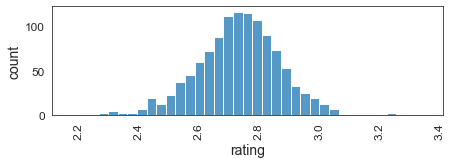

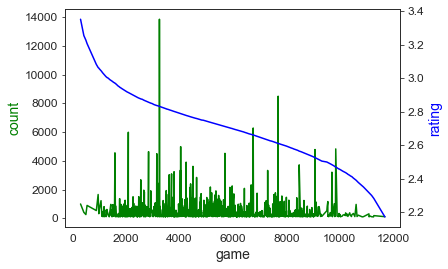

time: 656 ms (started: 2021-09-07 23:15:56 -03:00)


In [225]:
df_filter = df_ratings[df_ratings['count'] > 100]

plt.figure(figsize=(7,2))
sns.histplot(data=df_filter, x='mean')
plt.ylabel('count')
plt.xlabel('rating')
plt.xticks(rotation=90)
plt.show()

x = df_filter.index
y1 = df_filter['count']
y2 = df_filter['mean']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('game')
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('rating', color='b')

plt.show()

In [314]:
data_games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.4900,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.9900,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.2400,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.9900,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.3900,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.9900,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.9900,False,658870,"xropi,stev3ns",1 user reviews,NaN


time: 31 ms (started: 2021-09-08 00:00:51 -03:00)


In [315]:
data_games.dropna(subset=['id'], axis=0, inplace=True)

time: 31 ms (started: 2021-09-08 00:00:52 -03:00)


In [316]:
data_games.isna().sum()

publisher          8051
genres             3282
app_name              1
title              2049
url                   0
release_date       2066
tags                162
discount_price    31909
reviews_url           0
specs               669
price              1377
early_access          0
id                    0
developer          3298
sentiment          7181
metascore         29457
dtype: int64

time: 47 ms (started: 2021-09-08 00:00:56 -03:00)


In [337]:
df_games = data_games.copy()
df_games.id.astype('int64')

0        761140
1        643980
2        670290
3        767400
4        773570
          ...  
32130    773640
32131    733530
32132    610660
32133    658870
32134    681550
Name: id, Length: 32133, dtype: int64

time: 31 ms (started: 2021-09-08 00:07:30 -03:00)


In [338]:
df_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

time: 15 ms (started: 2021-09-08 00:07:30 -03:00)


In [318]:
df_games = data_games.set_index('id')

time: 15 ms (started: 2021-09-08 00:01:05 -03:00)


In [319]:
df_filter['title'] = df_games['title'].loc[df_filter.product_id].values
df_filter.head(10)

KeyError: "None of [Int64Index([431960, 245550, 365670, 374570, 387290, 107100,  35700,  35720,\n            317400, 237930,\n            ...\n            382850, 457330, 240720, 227160, 258180, 335330, 292630,  34830,\n            316390, 242800],\n           dtype='int64', name='id', length=1150)] are in the [index]"

time: 32 ms (started: 2021-09-08 00:01:07 -03:00)


In [322]:
df_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
developer          object
sentiment          object
metascore          object
dtype: object

time: 0 ns (started: 2021-09-08 00:01:50 -03:00)


In [300]:
df_filter.product_id

296      431960
420      245550
496      365670
540      374570
887      387290
          ...  
11126    335330
11196    292630
11267     34830
11279    316390
11693    242800
Name: product_id, Length: 1150, dtype: int64

time: 15 ms (started: 2021-09-07 23:57:31 -03:00)


In [305]:
df_games['title'].loc['761140']

'Lost Summoner Kitty'

time: 0 ns (started: 2021-09-07 23:58:57 -03:00)
